In [1]:
import pandas as pd
import fnmatch
import cv2
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import pickle
import time
import keras
from sklearn.model_selection import train_test_split
import keras_metrics
import matplotlib.pyplot as plt


In [2]:
#AlexNet Architecture for EC estimation
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(300,300,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 384)       8

In [3]:
Lab_tested_data = pd.read_csv('C:\\Users\\Mahmood Yousaf\\Desktop\\FYP\\Final-Year-Project-Soil-Analysis-using-machine-learning\\Lab Results\\Soil_Lab_Results - Sheet1.csv')

In [4]:
print(len(Lab_tested_data))
#Getting sample id for each image with its lab value
Sample_ID = Lab_tested_data.iloc[:,0]
EC_Value = Lab_tested_data.iloc[:,3]

1572


In [5]:
def load_images_from_folder(folder):
    Labels = []
    image_counter = 0
    for filename in os.listdir(folder):
        x = filename.split("_")
        id = float(x[0])
        img = cv2.imread(os.path.join(folder,filename))
        width = 1000
        height = 1000
        dim = (width, height)
        # resize image
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        img = img[500:800,500:800] #Resizing the image
        kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
        img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel.
        Result = Sample_ID.isin([id])
        Result = Sample_ID[Result];
        if len(Result) >= 1:
            print(image_counter)
            image_counter = image_counter + 1
            if len(Result) == 2:  
                Result = Sample_ID[Sample_ID==Result.iloc[1]].index.tolist()
                Id_1_index = Result[0]
                Id_2_index = Result[1]
                #Average of both inner and surface image soil result 
                EC_lab_value = (EC_Value[Id_2_index] + EC_Value[Id_2_index]) / 2
                #Assigning classs number 0,1,2,3
                if EC_lab_value <= 4.0:
                    Labels.append([filename,img,0])
                elif EC_lab_value > 4.0  and EC_lab_value <= 8:
                    Labels.append([filename,img,1])
                elif EC_lab_value > 8.0  and EC_lab_value <= 16:
                    Labels.append([filename,img,2])
                elif EC_lab_value > 16:
                    Labels.append([filename,img,3])
            elif len(Result==1):
                Result = Sample_ID[Sample_ID==Result.iloc[1]].index.tolist()
                Id_1_index = Result[0]
                EC_lab_value = EC_Value[Id_1_index]
                #Assigning classs number 0,1,2,3
                if EC_lab_value <= 4.0:
                    Labels.append([filename,img,0])
                elif EC_lab_value > 4.0  and EC_lab_value <= 8:
                    Labels.append([filename,img,1])
                elif EC_lab_value > 8.0  and EC_lab_value <= 16:
                    Labels.append([filename,img,2])
                elif EC_lab_value > 16:
                    Labels.append([filename,img,3])
        else:
            print(len(Result))
            print("Hi i am here for testing")
            continue
    return Labels

In [6]:
#loading dataset 
dataset = load_images_from_folder('C:\\Users\\Mahmood Yousaf\\Desktop\\FYP\\Dataset RGB\\Training_data')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
#Preparing data for model
X = []
Y = []
for data in dataset:
    X.append(data[1])
    Y.append(data[2])
print(Y)
print(len(X))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 

In [8]:
img_size = 300
X = np.array(X).reshape(-1, img_size, img_size, 3)
print(X[0].shape)
Y = to_categorical(Y)
print(Y[100])
print(X.shape)

(300, 300, 3)
[1. 0. 0.]
(1064, 300, 300, 3)


In [9]:
print(X.shape)
X_train, X_val, y_train, y_val = train_test_split(X, Y)
print(Y[522])

(1064, 300, 300, 3)
[1. 0. 0.]


In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
history=model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, validation_split=0.3)

Epoch 1/200


C:\Users\Mahmood Yousaf\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


18/18 [==============================] - 11s 354ms/step - loss: 32.1847 - accuracy: 0.9319 - precision: 0.9822 - recall: 0.8692 - f1_score: 0.9126 - val_loss: 1062.5186 - val_accuracy: 0.9917 - val_precision: 0.9812 - val_recall: 0.9691 - val_f1_score: 0.9751
Epoch 2/200
18/18 [==============================] - 3s 184ms/step - loss: 14.5516 - accuracy: 0.9767 - precision: 0.9816 - recall: 0.9801 - f1_score: 0.9809 - val_loss: 409.0893 - val_accuracy: 0.9917 - val_precision: 0.9819 - val_recall: 0.9857 - val_f1_score: 0.9838
Epoch 3/200
18/18 [==============================] - 3s 180ms/step - loss: 6.0296 - accuracy: 0.9785 - precision: 0.9818 - recall: 0.9886 - f1_score: 0.9852 - val_loss: 272.4769 - val_accuracy: 0.9917 - val_precision: 0.9821 - val_recall: 0.9907 - val_f1_score: 0.9864
Epoch 4/200
18/18 [==============================] - 3s 180ms/step - loss: 8.0269 - accuracy: 0.9695 - precision: 0.9824 - recall: 0.9914 - f1_score: 0.9869 - val_loss: 27.1812 - val_accuracy: 0.9917 -

Epoch 21/200
18/18 [==============================] - 3s 180ms/step - loss: 2.6326 - accuracy: 0.9821 - precision: 0.9829 - recall: 0.9977 - f1_score: 0.9903 - val_loss: 9.9689 - val_accuracy: 0.9917 - val_precision: 0.9830 - val_recall: 0.9977 - val_f1_score: 0.9903
Epoch 22/200
18/18 [==============================] - 3s 180ms/step - loss: 2.7266 - accuracy: 0.9767 - precision: 0.9831 - recall: 0.9978 - f1_score: 0.9904 - val_loss: 0.6325 - val_accuracy: 0.9917 - val_precision: 0.9831 - val_recall: 0.9978 - val_f1_score: 0.9904
Epoch 23/200
18/18 [==============================] - 3s 180ms/step - loss: 1.8062 - accuracy: 0.9713 - precision: 0.9831 - recall: 0.9978 - f1_score: 0.9904 - val_loss: 1.1229 - val_accuracy: 0.9917 - val_precision: 0.9830 - val_recall: 0.9978 - val_f1_score: 0.9904
Epoch 24/200
18/18 [==============================] - 3s 180ms/step - loss: 2.1841 - accuracy: 0.9767 - precision: 0.9831 - recall: 0.9979 - f1_score: 0.9905 - val_loss: 0.5941 - val_accuracy: 0.9

18/18 [==============================] - 3s 181ms/step - loss: 0.9803 - accuracy: 0.9803 - precision: 0.9844 - recall: 0.9981 - f1_score: 0.9912 - val_loss: 0.9515 - val_accuracy: 0.9792 - val_precision: 0.9845 - val_recall: 0.9980 - val_f1_score: 0.9912
Epoch 52/200
18/18 [==============================] - 3s 181ms/step - loss: 0.3236 - accuracy: 0.9839 - precision: 0.9845 - recall: 0.9980 - f1_score: 0.9912 - val_loss: 1.4115 - val_accuracy: 0.9750 - val_precision: 0.9845 - val_recall: 0.9980 - val_f1_score: 0.9912
Epoch 53/200
18/18 [==============================] - 3s 181ms/step - loss: 1.3866 - accuracy: 0.9731 - precision: 0.9845 - recall: 0.9979 - f1_score: 0.9912 - val_loss: 2.5921 - val_accuracy: 0.9917 - val_precision: 0.9845 - val_recall: 0.9979 - val_f1_score: 0.9912
Epoch 54/200
18/18 [==============================] - 3s 181ms/step - loss: 1.2460 - accuracy: 0.9767 - precision: 0.9845 - recall: 0.9979 - f1_score: 0.9912 - val_loss: 0.4091 - val_accuracy: 0.9875 - val_pre

Epoch 82/200
18/18 [==============================] - 3s 181ms/step - loss: 1.3745 - accuracy: 0.9910 - precision: 0.9870 - recall: 0.9979 - f1_score: 0.9924 - val_loss: 8.9009 - val_accuracy: 0.9958 - val_precision: 0.9871 - val_recall: 0.9979 - val_f1_score: 0.9925
Epoch 83/200
18/18 [==============================] - 3s 181ms/step - loss: 0.7965 - accuracy: 0.9910 - precision: 0.9871 - recall: 0.9979 - f1_score: 0.9925 - val_loss: 3.4845 - val_accuracy: 0.9958 - val_precision: 0.9871 - val_recall: 0.9980 - val_f1_score: 0.9925
Epoch 84/200
18/18 [==============================] - 3s 181ms/step - loss: 0.6637 - accuracy: 0.9946 - precision: 0.9872 - recall: 0.9980 - f1_score: 0.9925 - val_loss: 3.5915 - val_accuracy: 0.9958 - val_precision: 0.9872 - val_recall: 0.9980 - val_f1_score: 0.9926
Epoch 85/200
18/18 [==============================] - 3s 181ms/step - loss: 0.2189 - accuracy: 0.9982 - precision: 0.9873 - recall: 0.9980 - f1_score: 0.9926 - val_loss: 0.9603 - val_accuracy: 0.9

18/18 [==============================] - 3s 182ms/step - loss: 0.1935 - accuracy: 0.9964 - precision: 0.9890 - recall: 0.9981 - f1_score: 0.9935 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.9891 - val_recall: 0.9981 - val_f1_score: 0.9935
Epoch 113/200
18/18 [==============================] - 3s 181ms/step - loss: 1.1623 - accuracy: 0.9910 - precision: 0.9891 - recall: 0.9981 - f1_score: 0.9936 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.9891 - val_recall: 0.9981 - val_f1_score: 0.9936
Epoch 114/200
18/18 [==============================] - 3s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.9892 - recall: 0.9981 - f1_score: 0.9936 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.9892 - val_recall: 0.9981 - val_f1_score: 0.9936
Epoch 115/200
18/18 [==============================] - 3s 182ms/step - loss: 0.2145 - accuracy: 0.9928 - precision: 0.9892 - recall: 0.9981 - f1_score: 0.9937 - val_loss: 12.5030 - val_accura

18/18 [==============================] - 3s 179ms/step - loss: 0.1427 - accuracy: 0.9982 - precision: 0.9906 - recall: 0.9984 - f1_score: 0.9945 - val_loss: 7.8161 - val_accuracy: 0.9875 - val_precision: 0.9906 - val_recall: 0.9984 - val_f1_score: 0.9945
Epoch 143/200
18/18 [==============================] - 3s 182ms/step - loss: 2.3253 - accuracy: 0.9928 - precision: 0.9907 - recall: 0.9984 - f1_score: 0.9945 - val_loss: 0.4061 - val_accuracy: 0.9958 - val_precision: 0.9907 - val_recall: 0.9984 - val_f1_score: 0.9945
Epoch 144/200
18/18 [==============================] - 3s 182ms/step - loss: 7.7081 - accuracy: 0.9928 - precision: 0.9907 - recall: 0.9985 - f1_score: 0.9945 - val_loss: 2.0845 - val_accuracy: 0.9958 - val_precision: 0.9907 - val_recall: 0.9984 - val_f1_score: 0.9946
Epoch 145/200
18/18 [==============================] - 3s 180ms/step - loss: 0.5132 - accuracy: 0.9982 - precision: 0.9907 - recall: 0.9985 - f1_score: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 

18/18 [==============================] - 3s 180ms/step - loss: 0.8405 - accuracy: 0.9982 - precision: 0.9914 - recall: 0.9985 - f1_score: 0.9949 - val_loss: 3.6158 - val_accuracy: 0.9958 - val_precision: 0.9914 - val_recall: 0.9985 - val_f1_score: 0.9949
Epoch 173/200
18/18 [==============================] - 3s 180ms/step - loss: 1.0281 - accuracy: 0.9928 - precision: 0.9914 - recall: 0.9985 - f1_score: 0.9950 - val_loss: 5.4547 - val_accuracy: 0.9958 - val_precision: 0.9914 - val_recall: 0.9985 - val_f1_score: 0.9950
Epoch 174/200
18/18 [==============================] - 3s 181ms/step - loss: 4.9883 - accuracy: 0.9946 - precision: 0.9914 - recall: 0.9985 - f1_score: 0.9950 - val_loss: 8.5063 - val_accuracy: 0.9958 - val_precision: 0.9914 - val_recall: 0.9985 - val_f1_score: 0.9950
Epoch 175/200
18/18 [==============================] - 3s 181ms/step - loss: 0.0505 - accuracy: 1.0000 - precision: 0.9915 - recall: 0.9985 - f1_score: 0.9950 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 

In [11]:
model.evaluate(X_val,y_val)

9/9 [==============================] - 1s 148ms/step - loss: 155.4171 - accuracy: 0.9774 - precision: 0.9923 - recall: 0.9986 - f1_score: 0.9955


[155.4170684814453,
 0.9774436354637146,
 0.992339015007019,
 0.998589813709259,
 0.9954545497894287]

In [12]:
y_val[100]

array([1., 0., 0.], dtype=float32)

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])


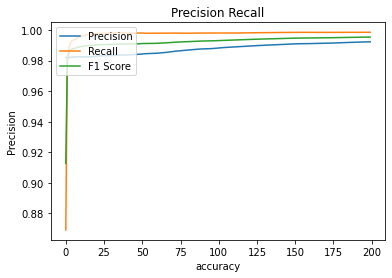

In [14]:
print(history.history.keys())
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['f1_score'])
plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlabel('accuracy')

plt.legend(['Precision', 'Recall','F1 Score'], loc='upper left')
plt.show()